In [1]:
from rxnemb import RXNEMB
from catemb import CatEmb
from catemb.recommend import random_init,recommend_by_random,recommend_by_dist
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
random_seed = 42

/opt/conda/envs/catemb/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
catemb_calc = CatEmb(device='cpu')
rxnemb_calc = RXNEMB(device='cpu')

## C–H arylation dataset

In [3]:
rxn_data = pd.read_csv("../dataset/rxn_data/aryl-scope-ligand.csv")
lig_smi_lst, rct1_smi_lst, rct2_smi_lst, pdt_smi_lst = rxn_data['ligand_smiles'].to_list(),rxn_data['electrophile_smiles'].to_list(),rxn_data['nucleophile_smiles'].to_list(),rxn_data['product_smiles'].to_list()
label = rxn_data['yield'].to_numpy()
len(set(lig_smi_lst)),len(rxn_data)

(24, 1536)

In [4]:
rxn_smi_lst = [f"{rct1_smi}.{rct2_smi}>>{pdt_smi}" for rct1_smi,rct2_smi,pdt_smi in zip(rct1_smi_lst,rct2_smi_lst,pdt_smi_lst)]
rxn_desc = rxnemb_calc.gen_rxn_emb(rxn_smi_lst).numpy()
lig_desc = catemb_calc.gen_desc(lig_smi_lst)

full_desc = np.concatenate([rxn_desc,lig_desc],axis=1)

rxn_lig_smi_lst = [f"{rct1_smi}.{rct2_smi}.{lig_smi}>>{pdt_smi}" for rct1_smi,rct2_smi,lig_smi,pdt_smi in zip(rct1_smi_lst,rct2_smi_lst,lig_smi_lst,pdt_smi_lst)]
rxn_only_desc = rxnemb_calc.gen_rxn_emb(rxn_lig_smi_lst).numpy()

Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1536/1536 [00:01<00:00, 784.93it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1536/1536 [00:01<00:00, 963.15it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 12/12 [00:06<00:00,  1.86it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1536/1536 [00:04<00:00, 373.40it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1536/1536 [00:01<00:00, 949.75it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


In [5]:
# save catemb which will be used in QSRP modeling of DRFP and rxnfp
np.savetxt("./gen_desc/aryl_scope_cat_emb.txt",lig_desc)
np.savetxt("./gen_desc/aryl_scope_cat_emb_smi.txt",lig_smi_lst,fmt="%s")

#### Without CatEmb

In [5]:
r2_ave = []
mae_ave = []
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
all_test_y = []
all_test_p = []
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(rxn_only_desc,label,test_size=0.2,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.3782, mae: 14.4392
seed: 1, r2: 0.5326, mae: 13.9372
seed: 2, r2: 0.4271, mae: 16.2101
seed: 3, r2: 0.4854, mae: 15.3976
seed: 4, r2: 0.5718, mae: 13.5024
seed: 5, r2: 0.5328, mae: 13.1684
seed: 6, r2: 0.4933, mae: 14.5491
seed: 7, r2: 0.4359, mae: 15.6349
seed: 8, r2: 0.4006, mae: 14.7004
seed: 9, r2: 0.5118, mae: 14.6787
r2_ave: 0.4770, mae_ave: 14.6218


#### With CatEmb

In [11]:
r2_ave = []
mae_ave = []
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
all_test_y = []
all_test_p = []
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(full_desc,label,test_size=0.2,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.7416, mae: 9.1389
seed: 1, r2: 0.7702, mae: 8.9020
seed: 2, r2: 0.7612, mae: 9.5669
seed: 3, r2: 0.7580, mae: 9.5661
seed: 4, r2: 0.8042, mae: 8.3526
seed: 5, r2: 0.7694, mae: 9.0465
seed: 6, r2: 0.7926, mae: 8.9150
seed: 7, r2: 0.7320, mae: 9.8149
seed: 8, r2: 0.6824, mae: 9.8401
seed: 9, r2: 0.7681, mae: 9.0840
r2_ave: 0.7580, mae_ave: 9.2227


R2: 0.7416, MAE: 9.1389


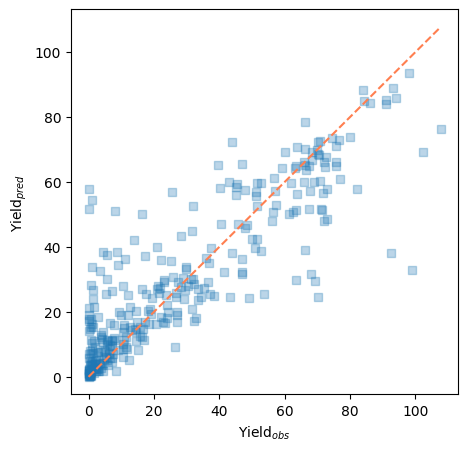

R2: 0.7702, MAE: 8.9020


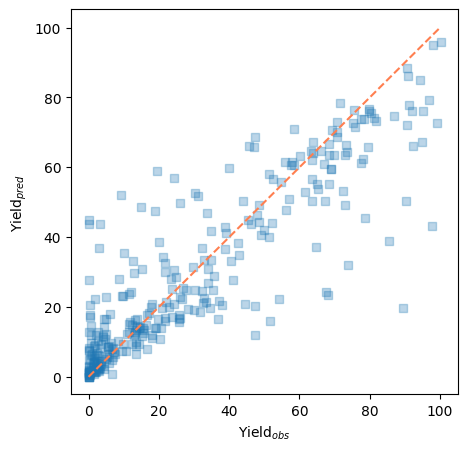

R2: 0.7612, MAE: 9.5669


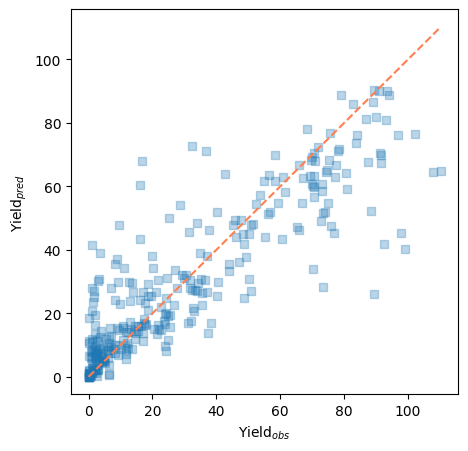

R2: 0.7580, MAE: 9.5661


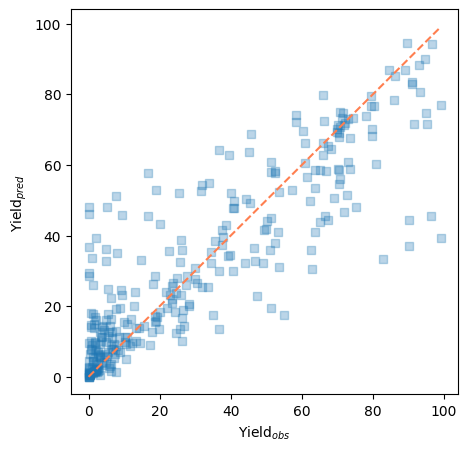

R2: 0.8042, MAE: 8.3526


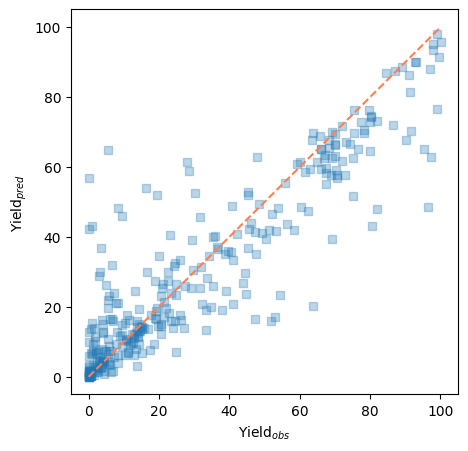

R2: 0.7694, MAE: 9.0465


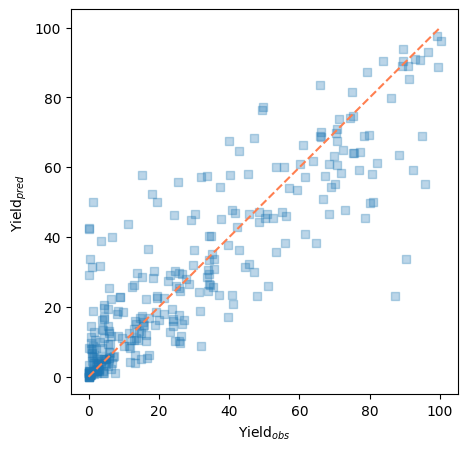

R2: 0.7926, MAE: 8.9150


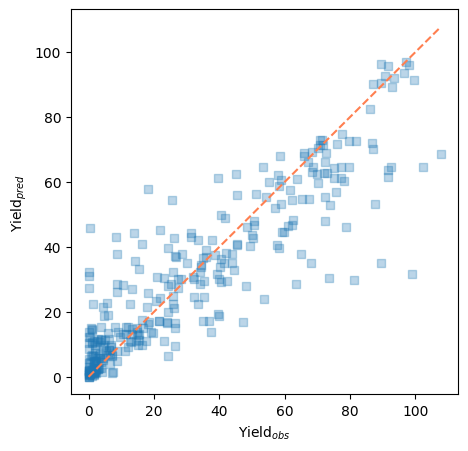

R2: 0.7320, MAE: 9.8149


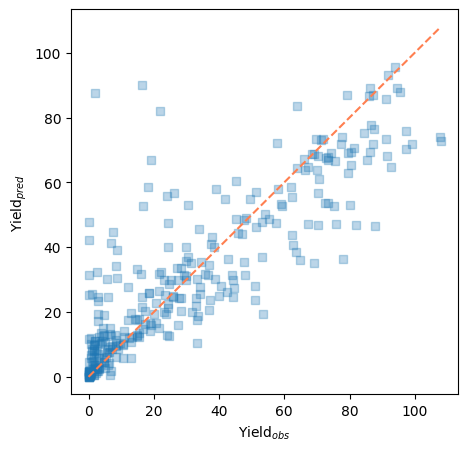

R2: 0.6824, MAE: 9.8401


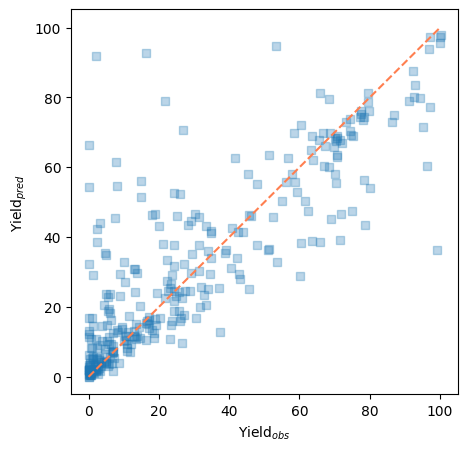

R2: 0.7681, MAE: 9.0840


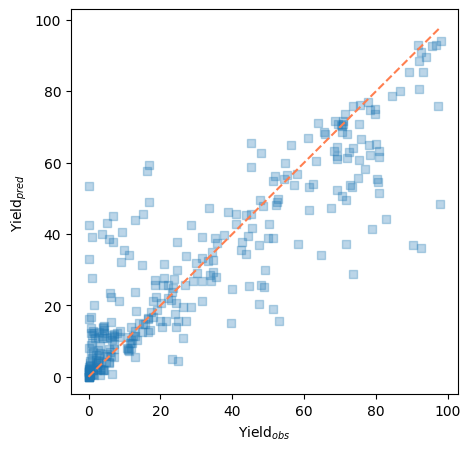

In [13]:
for trial in range(10):
    print(f"R2: {r2_score(all_test_y[trial],all_test_p[trial]):.4f}, MAE: {mean_absolute_error(all_test_y[trial],all_test_p[trial]):.4f}")
    plt.figure(figsize=(5,5))
    plt.scatter(all_test_y[trial],all_test_p[trial],alpha=0.3,marker="s")
    plt.plot([min(all_test_y[trial]),max(all_test_y[trial])],[min(all_test_y[trial]),max(all_test_y[trial])],"--",color="coral")
    plt.xlabel("Yield$_{obs}$")
    plt.ylabel("Yield$_{pred}$")
    plt.show()
    

## Asymmetric thiol addition dataset

In [6]:
rxn_data = pd.read_csv("../dataset/rxn_data/NS_acetal_dataset_with_pdt.csv")
rxn_data

,Unnamed: 0,Imine,Thiol,Catalyst,ΔΔG,Product
0,0,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1,1,O=C(/N=C/c1ccccc1)c1ccccc1,CCS,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.501759,CCSC(NC(=O)c1ccccc1)c1ccccc1
2,2,O=C(/N=C/c1ccccc1)c1ccccc1,SC1CCCCC1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,0.650584,O=C(NC(SC1CCCCC1)c1ccccc1)c1ccccc1
3,3,O=C(/N=C/c1ccccc1)c1ccccc1,COc1ccc(S)cc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.238109,COc1ccc(SC(NC(=O)c2ccccc2)c2ccccc2)cc1
4,4,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3ccccc3)cc3ccccc3c2-c2c(c(-c3ccc...,1.179891,O=C(NC(Sc1ccccc1)c1ccc(C(F)(F)F)cc1)c1ccccc1
...,...,...,...,...,...,...
1070,1070,O=C(/N=C/c1ccccc1)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,O=C(NC(Sc1ccccc1)c1ccccc1)c1ccccc1
1071,1071,O=C(/N=C/c1ccccc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.531803,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccccc1
1072,1072,O=C(/N=C/c1ccc(C(F)(F)F)cc1)c1ccccc1,Cc1ccccc1S,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.370104,Cc1ccccc1SC(NC(=O)c1ccccc1)c1ccc(C(F)(F)F)cc1
1073,1073,O=C(/N=C/c1cccc2ccccc12)c1ccccc1,Sc1ccccc1,O=P1(O)Oc2c(-c3cc(C(F)(F)F)cc(C(F)(F)F)c3)cc3c...,1.301167,O=C(NC(Sc1ccccc1)c1cccc2ccccc12)c1ccccc1


In [7]:
imine_lst = rxn_data['Imine'].to_list()
thiol_lst = rxn_data['Thiol'].to_list()
cat_lst = rxn_data['Catalyst'].to_list()
pdt_lst = rxn_data['Product'].to_list()
label = rxn_data['ΔΔG'].to_numpy()

In [8]:
cat_label_map = {}
for cat,l in zip(cat_lst,label):
    if cat not in cat_label_map:
        cat_label_map[cat] = []
    cat_label_map[cat].append(l)
cat_label_lst = sorted([[cat,np.mean(l)] for cat,l in cat_label_map.items()],key=lambda x:x[1])

In [9]:
rxn_lst = [f"{imine}.{thiol}>>{pdt}" for imine,thiol,pdt in zip(imine_lst,thiol_lst,pdt_lst)]
rxn_emb_arr = rxnemb_calc.gen_rxn_emb(rxn_lst).numpy()
cat_emb_arr = catemb_calc.gen_desc(cat_lst)
rxn_cat_lst = [f"{imine}.{thiol}.{cat}>>{pdt}" for imine,thiol,cat,pdt in zip(imine_lst,thiol_lst,cat_lst,pdt_lst)]
rxn_only_arr = rxnemb_calc.gen_rxn_emb(rxn_cat_lst).numpy()
full_emb_arr = np.concatenate([rxn_emb_arr,cat_emb_arr],axis=1)

Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1075/1075 [00:01<00:00, 624.75it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1075/1075 [00:01<00:00, 668.96it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 9/9 [00:04<00:00,  1.95it/s]
Processing...


[INFO] rxn_emb_tmp/rct_smiles_0.csv is processing...


100%|██████████| 1075/1075 [00:04<00:00, 223.12it/s]
Done!
Processing...


[INFO] rxn_emb_tmp/pdt_smiles_0.csv is processing...


100%|██████████| 1075/1075 [00:01<00:00, 745.24it/s]
Done!


[INFO] Generating reaction embedding...


100%|██████████| 9/9 [00:06<00:00,  1.29it/s]


In [ ]:
np.savetxt("./gen_desc/thiol_add_cat_emb.txt",cat_emb_arr)
np.savetxt("./gen_desc/thiol_add_cat_emb_smi.txt",cat_lst,fmt="%s")

#### Without CatEmb

In [27]:
r2_ave = []
mae_ave = []
all_test_y = []
all_test_p = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(rxn_only_arr,label,test_size=475/1075,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")

    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.2111, mae: 0.4555
seed: 1, r2: 0.1449, mae: 0.4546
seed: 2, r2: 0.2689, mae: 0.4402
seed: 3, r2: 0.2119, mae: 0.4646
seed: 4, r2: 0.1404, mae: 0.4723
seed: 5, r2: 0.2192, mae: 0.4552
seed: 6, r2: 0.2204, mae: 0.4480
seed: 7, r2: 0.3068, mae: 0.4331
seed: 8, r2: 0.1909, mae: 0.4610
seed: 9, r2: 0.2438, mae: 0.4508
r2_ave: 0.2158, mae_ave: 0.4535


### With CatEmb

In [28]:
r2_ave = []
mae_ave = []
all_test_y = []
all_test_p = []
#model = deepcopy(model2)
model = ExtraTreesRegressor(n_estimators=500,random_state=random_seed,n_jobs=-1)
for seed in range(10):
    train_x,test_x,train_y,test_y = train_test_split(full_emb_arr,label,test_size=475/1075,random_state=seed)
    model.fit(train_x,train_y)
    test_p = model.predict(test_x)
    all_test_y.append(test_y)
    all_test_p.append(test_p)
    r2 = r2_score(test_y,test_p)
    mae = mean_absolute_error(test_y,test_p)
    print(f"seed: {seed}, r2: {r2:.4f}, mae: {mae:.4f}")

    r2_ave.append(r2)
    mae_ave.append(mae)
r2_ave = np.mean(r2_ave)
mae_ave = np.mean(mae_ave)
print(f"r2_ave: {r2_ave:.4f}, mae_ave: {mae_ave:.4f}")

seed: 0, r2: 0.8863, mae: 0.1539
seed: 1, r2: 0.8930, mae: 0.1500
seed: 2, r2: 0.8962, mae: 0.1495
seed: 3, r2: 0.8955, mae: 0.1472
seed: 4, r2: 0.9018, mae: 0.1483
seed: 5, r2: 0.8980, mae: 0.1551
seed: 6, r2: 0.8853, mae: 0.1536
seed: 7, r2: 0.8980, mae: 0.1532
seed: 8, r2: 0.9036, mae: 0.1477
seed: 9, r2: 0.8911, mae: 0.1614
r2_ave: 0.8949, mae_ave: 0.1520


R2: 0.8863, MAE: 0.1539


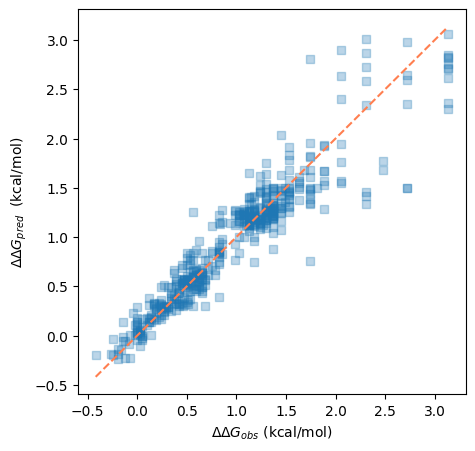

R2: 0.8930, MAE: 0.1500


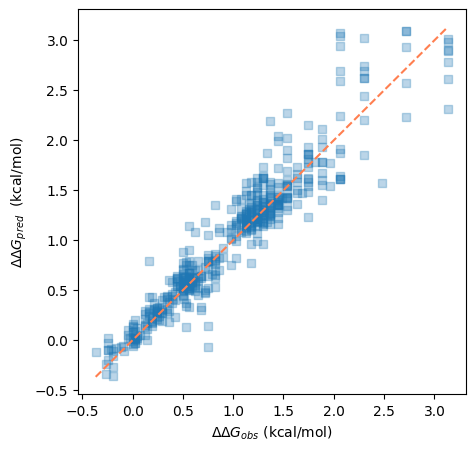

R2: 0.8962, MAE: 0.1495


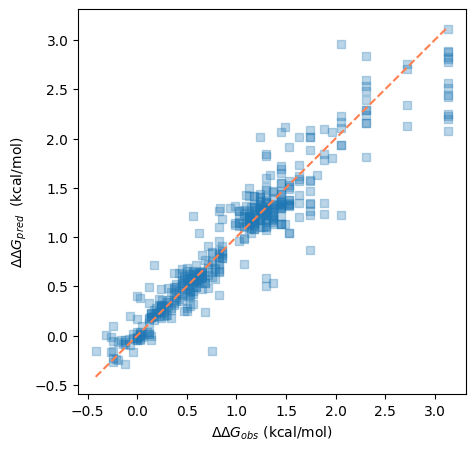

R2: 0.8955, MAE: 0.1472


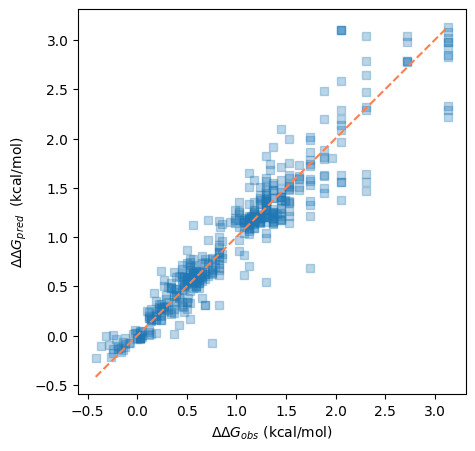

R2: 0.9018, MAE: 0.1483


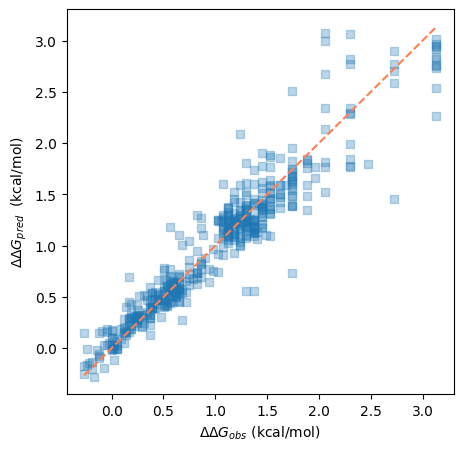

R2: 0.8980, MAE: 0.1551


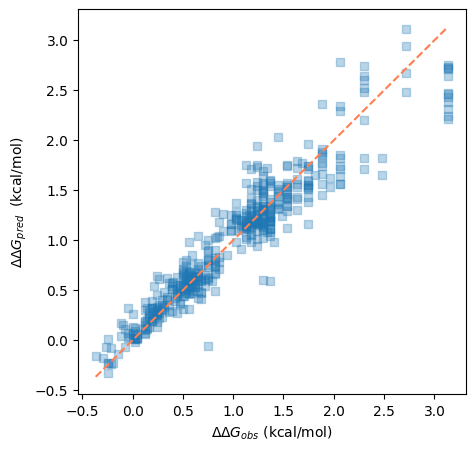

R2: 0.8853, MAE: 0.1536


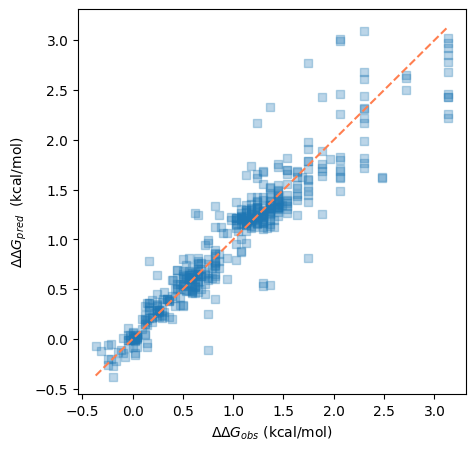

R2: 0.8980, MAE: 0.1532


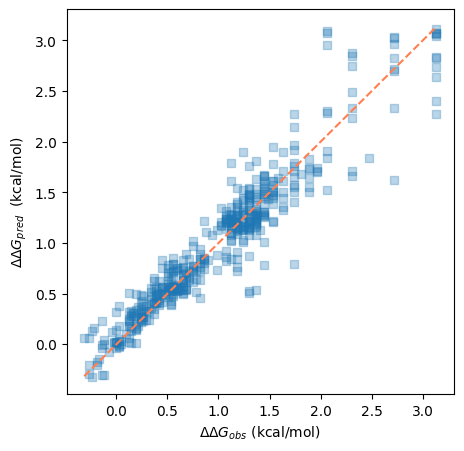

R2: 0.9036, MAE: 0.1477


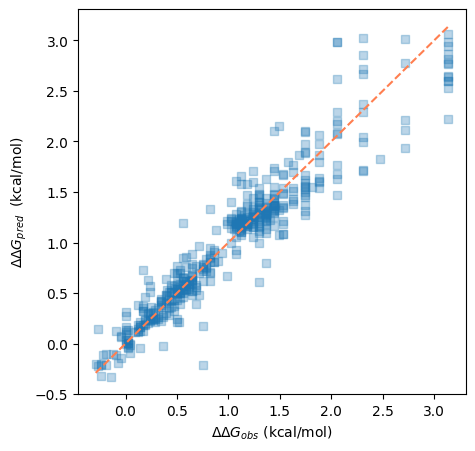

R2: 0.8911, MAE: 0.1614


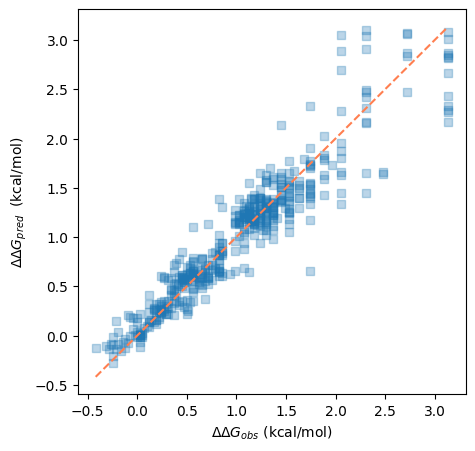

In [29]:
for trial in range(10):
    print(f"R2: {r2_score(all_test_y[trial],all_test_p[trial]):.4f}, MAE: {mean_absolute_error(all_test_y[trial],all_test_p[trial]):.4f}")
    plt.figure(figsize=(5,5))
    plt.scatter(all_test_y[trial],all_test_p[trial],alpha=0.3,marker="s")
    plt.plot([min(all_test_y[trial]),max(all_test_y[trial])],[min(all_test_y[trial]),max(all_test_y[trial])],"--",color="coral")
    plt.xlabel("$\Delta$$\Delta$$G$$_{obs}$ (kcal/mol)")
    plt.ylabel("$\Delta$$\Delta$$G$$_{pred}$  (kcal/mol)")
    plt.show()
    